In [1]:
import scipy.ndimage as snd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import skimage.measure
import os
import json

from bimmquant.utils import tools

# Artificial data generation

In this notebook, we generate an artificial dataset that can be used as input for the notebook `examples/art_data_quantification_and_segmentation.ipynb`. The data size is 300 x 300 x 50 voxels and contains two phases (materials).

**Parameters:**

* `sigma_b_0`: Determines image feature size (blob sizes)
* `V1_target`: Target volume fraction
* `I1`, `I2`: Phase intensities  
* `sigma_b`: blur level (image resolution)
* `sigma_n`: noise level

**Data generation:**

First, a Gaussian filter (kernel std `sigma_b_0`) is applied to standard Gaussian noise (mean 0, std 1) (see the figure "Blurred Gaussian noise" below). This volume is then binarized to acheive the target volume fraction `V1_target` (figure "Binarized" below) and intensities are assigned to the two phases according to `I1` and `I2`. This is the final ground truth phantom, where ground truth volume fractions are found by counting voxels, and interface area is measured using marching cubes. 

Finally, to mimic the Gaussian blurring and noise resulting from a 3D X-ray CT scan, a Gaussian filter (kernel std `sigma_b`) is applied and Gaussian noise (std `sigma_n`) is added (figure "Final artificial data" below). 


In [2]:
def generate_2phased_randomstruct(sigma_b_0, Nx, Ny, Nz, sigma_b, sigma_n, I1, I2, V1_target, 
                                  plot = False, seed = 999):
    
    #Set random seed
    np.random.seed(seed)
    
    #Blurred Gaussian noise
    vol_init = np.random.normal(0, 1, size=(Nx, Ny, Nz))
    vol_blur=snd.gaussian_filter(vol_init, sigma=sigma_b_0)
    
    if plot:
        tools.plot_center_slices(vol_blur, colorbar=True, title='Blurred Gaussian noise')

    #Bizarize to reach target volume fractions
    binarize_level=scipy.stats.norm.ppf(V1_target, loc=0, scale=np.std(vol_blur)) #inverse of cdf

    vol_bin=(vol_blur>binarize_level)*1
    
    if plot:
        tools.plot_center_slices(vol_bin, colorbar=True, title='Binarized')

    # Measure final volume fractions
    V1 = np.sum(vol_bin==0)/len(vol_bin.ravel())
    V2 = np.sum(vol_bin==1)/len(vol_bin.ravel())
    print('Volume fractions:')
    print('V1= ', V1, '\n V2 = ', V2)

    # Measure interface area
    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(vol_bin, binarize_level)
    A_march=skimage.measure.mesh_surface_area(verts, faces)
    print('Interface area, marching cubes: \n A_march = ', A_march)
    print('Interface area per volume: A_march/(Nx*Ny*Nz) = ', A_march/(Nx*Ny*Nz))

    # Set phase intensities
    vol_I = vol_bin.astype(np.float64)
    vol_I[vol_bin == 0] = I1
    vol_I[vol_bin == 1] = I2


    # Blur and add noise
    vol = snd.gaussian_filter(vol_I, sigma=sigma_b) + np.random.normal(0, sigma_n, size=np.shape(vol_bin))
    
    if plot:
        tools.plot_center_slices(vol, title='Final artificial data')

        plt.figure()
        _=plt.hist(vol.ravel(), bins=100)

        
    ground_truth_dict = {}
    ground_truth_dict['I'] = [I1, I2]
    ground_truth_dict['sigma_b'] = sigma_b
    ground_truth_dict['sigma_n'] = sigma_n
    ground_truth_dict['V'] = [V1, V2]
    ground_truth_dict['A_per_volume'] = A_march/(Nx*Ny*Nz)
    
    return vol, ground_truth_dict

In [3]:
Nx, Ny, Nz = 300, 300, 50 #volume size
sigma_b_0 = 20


V1_target = 0.5
I1 = 0.1
I2 = 0.9
sigma_b = 3.
sigma_n = 0.1

Volume fractions:
V1=  0.49250422222222223 
 V2 =  0.5074957777777778
Interface area, marching cubes: 
 A_march =  78565.9296875
Interface area per volume: A_march/(Nx*Ny*Nz) =  0.01745909548611111


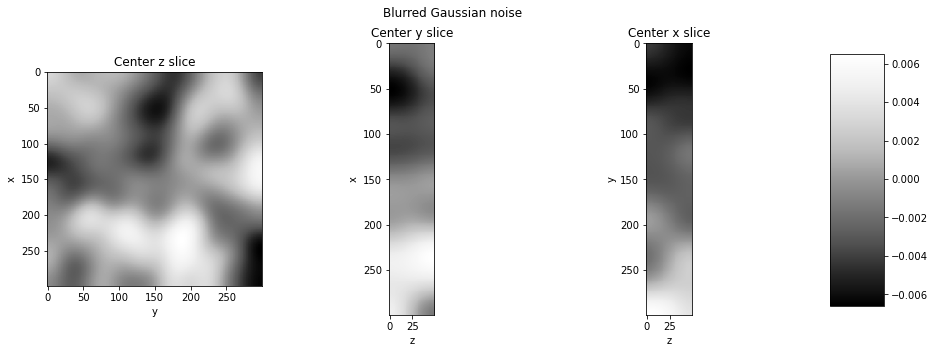

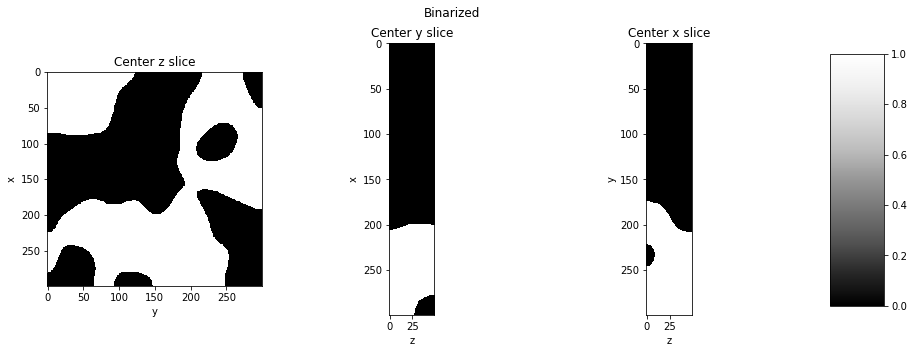

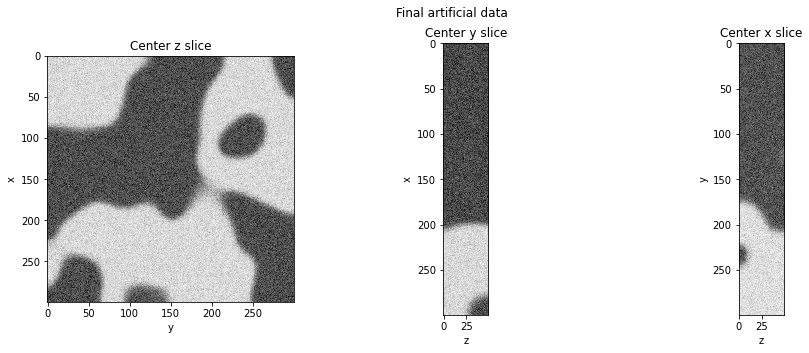

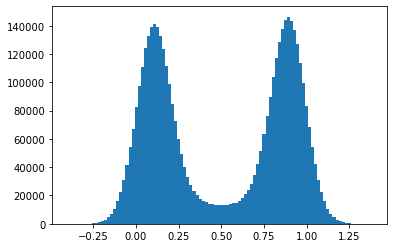

In [4]:
vol, ground_truth_dict = generate_2phased_randomstruct(sigma_b_0, Nx, Ny, Nz, sigma_b, sigma_n, I1, I2, V1_target,
                                                       plot=True, seed = 999)

## Save dataset and ground truth values


In [5]:
# Artificial data, .npy
np.save(os.path.join('example_data', 'artificial_data', 'art_data_2phases.npy'), vol)

# Ground truth parameters, .json
json.dump( ground_truth_dict, open( os.path.join('example_data', 'artificial_data', 'art_data_2phases_GT.json'), 'w' ) )